In [1]:
# 필요한 패키지 모두 import #
import os
import random

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier 
#LGBM 사용할 예정
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

plt.rc('font', family='NanumBarunGothic')

In [2]:
#데이콘 Basic 음악 장르 분류 AI 경진대회
#https://dacon.io/competitions/official/236056/data
#데이터 로드 및 확인
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

In [3]:
train.head(3)

,ID,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,genre
0,TRAIN_00000,0.3341,0.9231,10,0.8540,0.3797,0.008,0.0002,0.7697,0.7902,0.5391,175,trap
1,TRAIN_00001,0.6344,0.5955,10,0.2826,0.1378,0.000,0.7137,0.1597,0.4162,0.3043,513,techno
2,TRAIN_00002,0.3983,0.1107,8,0.2459,0.0247,0.774,0.0000,0.5105,0.4291,0.2324,151,Trap Metal


## 랜덤시드 고정

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(52) # Seed 고정

## EDA

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25383 entries, 0 to 25382
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                25383 non-null  object 
 1   danceability      25383 non-null  float64
 2   energy            25383 non-null  float64
 3   key               25383 non-null  int64  
 4   loudness          25383 non-null  float64
 5   speechiness       25383 non-null  float64
 6   acousticness      25383 non-null  float64
 7   instrumentalness  25383 non-null  float64
 8   liveness          25383 non-null  float64
 9   valence           25383 non-null  float64
 10  tempo             25383 non-null  float64
 11  duration          25383 non-null  int64  
 12  genre             25383 non-null  object 
dtypes: float64(9), int64(2), object(2)
memory usage: 2.5+ MB


In [8]:
train.describe()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration
count,25383.000000,25383.000000,25383.000000,25383.000000,25383.000000,25383.000000,25383.000000,25383.000000,25383.000000,25383.000000,25383.000000
mean,0.544519,0.642106,5.368239,0.523904,0.271701,0.178736,0.309931,0.324461,0.403999,0.503558,253.697514
std,0.242362,0.275050,3.660011,0.209811,0.276586,0.272155,0.399725,0.254626,0.286148,0.222104,103.020340
min,0.000000,0.000000,0.000000,0.000000,0.001100,0.000000,0.000000,0.000000,0.000000,0.007300,28.000000
25%,0.340500,0.410000,1.000000,0.372900,0.062950,0.003700,0.000000,0.138100,0.148000,0.322350,182.000000
50%,0.553400,0.701300,6.000000,0.538300,0.129600,0.035800,0.006500,0.200700,0.361800,0.483500,227.000000
75%,0.759900,0.895700,9.000000,0.683600,0.450200,0.237500,0.814000,0.501500,0.640800,0.659350,304.000000
max,1.000000,1.000000,11.000000,0.999500,1.000000,0.999900,1.000000,1.000000,1.000000,1.000000,897.000000


In [9]:
train.dtypes

ID                   object
danceability        float64
energy              float64
key                   int64
loudness            float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration              int64
genre                object
dtype: object

In [10]:
pd.set_option('display.max_rows', None) # 전체 행 보이기

In [11]:
X = train.drop(["ID", "genre"], axis = 1) #열 기준으로 id와 genre 제거
y = train[['genre']] # 장르만 가져오기
test = test.drop(["ID"], axis = 1) #id 제거

## 왜도와 첨도 확인해보기

In [24]:
from scipy.stats import skew, kurtosis
df0 = X.apply(['skew', 'kurtosis']).T
df0.loc[ (df0['skew'] >= 2) | (df0['kurtosis'] >= 3) ]
# 왜도가 2 이상이거나 첨도가 3 이상인 변수를 찾고, 로그 변환을 취하고자 함
# -> 없음!

,skew,kurtosis


## 표준화

In [25]:
from sklearn.preprocessing import StandardScaler

## StandardScaler객체 생성.
scaler = StandardScaler()
## StandardScaler 로 데이터 셋 변환. fit( ), transform( ) 호출.  
scaler.fit(X)
X_scaled = scaler.transform(X)
## transform( )시 scale 변환된 데이터 셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환.
X_df_scaled = pd.DataFrame(data = X_scaled, columns = list(X.columns))

## PCA

In [29]:
features = X_df_scaled.T
covmat = np.cov(features)
covmat

array([[ 1.00003940e+00, -3.45007873e-01, -1.11378062e-02,
        -2.43284343e-01,  2.06572872e-01,  1.09234787e-01,
        -6.65757720e-02, -2.11662032e-01,  3.70574195e-01,
        -1.96666272e-01, -5.02824185e-02],
       [-3.45007873e-01,  1.00003940e+00,  4.50360973e-02,
         5.83931044e-01, -1.61765517e-01, -4.85598529e-01,
         3.22121971e-01,  2.34953872e-01, -3.37755130e-02,
        -1.44818070e-02,  2.98309704e-01],
       [-1.11378062e-02,  4.50360973e-02,  1.00003940e+00,
        -7.87482119e-03, -3.14388778e-02, -7.31372095e-03,
         7.02784951e-02,  1.97350526e-04,  2.72285305e-02,
        -1.53656227e-02,  6.93494376e-02],
       [-2.43284343e-01,  5.83931044e-01, -7.87482119e-03,
         1.00003940e+00,  5.64241466e-02, -2.51505197e-01,
        -1.86592358e-01,  1.84931443e-01,  7.29222435e-02,
         1.94193611e-01, -1.09721553e-01],
       [ 2.06572872e-01, -1.61765517e-01, -3.14388778e-02,
         5.64241466e-02,  1.00003940e+00,  2.07704699e-01,
  

In [31]:
import numpy.linalg as lin
lin.eig(covmat)

(array([2.68012252, 1.96562173, 1.2604382 , 0.21126839, 0.3907213 ,
        0.4531354 , 0.6150244 , 0.68863555, 1.00273465, 0.81120809,
        0.92152315]),
 array([[ 2.65100250e-01, -2.95136020e-01, -5.56476798e-01,
         -2.13246800e-01,  1.92191237e-01,  6.07164607e-01,
          1.84158100e-01,  1.60174176e-01, -1.12666597e-01,
         -9.79278678e-02, -6.00236544e-03],
        [-4.29245592e-01,  3.52269808e-01, -2.55978630e-01,
         -6.96368991e-01,  2.16026035e-01, -8.56275414e-02,
         -2.77687840e-01, -5.71170541e-02, -1.98938934e-02,
          5.14246898e-02, -6.15377162e-02],
        [-5.26371363e-02, -3.55458139e-02, -1.38580817e-01,
         -1.32253449e-03, -5.94094221e-03,  2.87682452e-02,
          6.88077532e-02,  1.33902340e-01,  9.59219581e-01,
          1.61372382e-01,  8.41958131e-02],
        [-1.45715103e-01,  5.63952754e-01, -1.82218799e-01,
          5.08720841e-01, -2.76383473e-03,  4.53452536e-01,
         -2.07728113e-01, -1.42758481e-02, -4.0135

In [32]:
eigenvalues = lin.eig(covmat)[0]
eigenvectors = lin.eig(covmat)[1]

In [35]:
def new_coordinates(x,eigenvectors):
    for i in range(eigenvectors.shape[0]):
        if i == 0:
            new = [x.dot(eigenvectors.T[i])]
        else:
            new = np.concatenate((new,[x.dot(eigenvectors.T[i])]),axis=0)
    return new.T
new_coordinates(X_df_scaled,eigenvectors)

array([[-0.2401447 ,  2.83547833, -1.03293293, ...,  1.15691277,
         0.41015629,  1.06594494],
       [-1.63572297, -2.38354552, -0.93548686, ...,  1.09812164,
        -0.61499432, -0.05740294],
       [ 1.90314478, -1.4256707 ,  1.55461745, ...,  0.8699986 ,
         1.19759467,  1.77707727],
       ...,
       [-2.03393238, -0.35176756,  1.09322941, ...,  1.00423515,
        -0.65359957, -1.50634447],
       [ 2.44316517,  1.22112285,  1.79557845, ..., -0.98562736,
        -1.0784706 , -1.04356712],
       [ 1.11874993, -0.50229884, -0.37965684, ...,  0.80852824,
         0.99741291,  0.1999675 ]])

In [36]:
#PCA 구현
def PCA(x,number):
    scaler = StandardScaler()
    xx = scaler.fit_transform(x) #scaling
    features = xx.T
    cov_matrix = np.cov(features) #공분산
    
    eigenvalues = lin.eig(covmat)[0] #eigenvalue
    eigenvectors = lin.eig(covmat)[1] #eigenvector
    
    new_coordinates(xx,eigenvectors)
    
    new_coordinate = new_coordinates(xx,eigenvectors)
    
    index = eigenvalues.argsort() #작은 것에서 큰 순서대로 나열한 eigenvalues 배열의 인덱스를 반환

    index = list(index)
    
    for i in range(number):
        if i==0:
            new = [new_coordinate[:,index.index(i)]]
        else:
            new = np.concatenate(([new_coordinate[:,index.index(i)]],new),axis=0)
    return new.T #모든 고유벡터 축으로 projection하여 새로운 축에 나타난 데이터 return


In [121]:
PCA(X_df_scaled, 4) #4 : 0.6569

array([[-0.2401447 ,  1.15691277,  0.41015629,  1.06594494],
       [-1.63572297,  1.09812164, -0.61499432, -0.05740294],
       [ 1.90314478,  0.8699986 ,  1.19759467,  1.77707727],
       ...,
       [-2.03393238,  1.00423515, -0.65359957, -1.50634447],
       [ 2.44316517, -0.98562736, -1.0784706 , -1.04356712],
       [ 1.11874993,  0.80852824,  0.99741291,  0.1999675 ]])

## 독립변수(X), 종속변수(y)로 나누기

In [122]:
X_train, X_valid, y_train, y_valid = train_test_split(X_df_scaled, y, test_size = 0.2) 
#8:2 비율로 train set과 valid set을 분리했음. test 데이터는 결과 제출용

## 모델링 : LGBM

In [65]:
def evaluate_macroF1_lgb(truth, predictions):  
    pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', f1, True)


In [123]:
model = LGBMClassifier(n_estimators=400, learning_rate = 0.05) 
#LGBM의 하이퍼 파라미터 중 n_estimators와 learning_rate은 
#전자는 "몇 개의 모델을 합칠 건지 지정"하고
#후자는 학습률이며, 모델이 최적화되는(최적해에 접근하는) 과정에서 
#learning_rate만큼 이동시키면서 최적해에 도달한다.
#경사하강법에 관련된 개념으로 이해하면 된다.

#사이킷런 래퍼 LIghtGBM을 사용했음.
#파이썬 래퍼 LightGBM은 하이퍼파라미터의 명칭이 다른 경우가 존재함.

evals = [(X_train, y_train), (X_valid, y_valid)] 
#eval_set에 들어갈 내용으로, n_estimators만큼 반복적으로 학습을 수행할 때마다 
#얼마나 성능이 향상되었는지 X_valid, y_valid를 검증데이터로 인식 및 검증케함.

In [124]:
fit_params={"early_stopping_rounds":50, 
            "eval_metric" : evaluate_macroF1_lgb, 
            "eval_set" : evals,
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': True,
            'categorical_feature': 'auto'}
model.fit(X_train,y_train, **fit_params)
###GBM은 여러 개의 estimator가 순차적으로 오류를 개선하면서 weight을 update하는 방식
###그래서 estimator를 재학습하고 검증 데이터로 다시 오류를 산출하여 평가함
###이 과정에서 eval_set 속 evals가 필요한 것!

##eval_set은 검증 세트를 지정하는 파라미터.
##학습은  (X_train, y_train), 검증은 (X_test, y_test) 데이터 세트를 이용하라는 것
##eval_set = [(X_valid, y_valid)]라는 코드가 저 명확하긴 함.
##저자는 데이터가 적다면 valid 데이터 대신 test 값을 사용한다고 하는데, 
##이 경우 data leakage에 해당하는 것 같아 주의 필요.



##early_stopping_round : validation(검증) 데이터 셋에서 평가 지표가 더이상
##향상되지 않으면 정지함. 평가지표의 향상이 n round 이상 지속되면 학습을 정지한다.

##eval_metric : 검증데이터로 loss 측정 시에 사용하는 방법
## logloss는 이진 분류에 사용된다.
## 해당 대회를 위해서라면 eval_metric에 f1_score를 최대화시키는 함수를 만들어
## 함수를 삽입할 수 있다.
### 참고 : https://www.inflearn.com/questions/344831/lightgbm-eval-metric-%EC%A7%88%EB%AC%B8%EC%9E%85%EB%8B%88%EB%8B%A4


##verbose : verbose가 있으면 함수 수행시 발생하는 상세한 정보들을 표준 출력으로 
##자세히 내보낼 것인가를 나타냄.
##보통 0 은 출력하지 않고, 1은 자세히, 2는 함축적인 정보만 출력하는 형태

valid_pred = model.predict(X_valid)
#valid data를 예측한 모델 값을 valid_pred 변수에 할당
print("현재 Macro F1 Score의 검증 점수는 {}입니다.".format(f1_score(valid_pred, y_valid, average = "macro"))) 
#macro f1-score 값을 valid 데이터로 확인해봤음.

[1]	training's multi_logloss: 2.28221	training's macroF1: 0.263269	valid_1's multi_logloss: 2.29928	valid_1's macroF1: 0.25425
Training until validation scores don't improve for 50 rounds
[2]	training's multi_logloss: 2.08159	training's macroF1: 0.539595	valid_1's multi_logloss: 2.10961	valid_1's macroF1: 0.522444
[3]	training's multi_logloss: 1.93121	training's macroF1: 0.597769	valid_1's multi_logloss: 1.96716	valid_1's macroF1: 0.566636
[4]	training's multi_logloss: 1.8098	training's macroF1: 0.63116	valid_1's multi_logloss: 1.85441	valid_1's macroF1: 0.588442
[5]	training's multi_logloss: 1.70727	training's macroF1: 0.653857	valid_1's multi_logloss: 1.75972	valid_1's macroF1: 0.607131
[6]	training's multi_logloss: 1.61898	training's macroF1: 0.670849	valid_1's multi_logloss: 1.6776	valid_1's macroF1: 0.617937
[7]	training's multi_logloss: 1.54208	training's macroF1: 0.678502	valid_1's multi_logloss: 1.60768	valid_1's macroF1: 0.622623
[8]	training's multi_logloss: 1.4744	training's

[66]	training's multi_logloss: 0.568183	training's macroF1: 0.820696	valid_1's multi_logloss: 0.868142	valid_1's macroF1: 0.655338
[67]	training's multi_logloss: 0.564002	training's macroF1: 0.822662	valid_1's multi_logloss: 0.866925	valid_1's macroF1: 0.654906
[68]	training's multi_logloss: 0.559994	training's macroF1: 0.824078	valid_1's multi_logloss: 0.866014	valid_1's macroF1: 0.655169
[69]	training's multi_logloss: 0.55617	training's macroF1: 0.825987	valid_1's multi_logloss: 0.865202	valid_1's macroF1: 0.655722
[70]	training's multi_logloss: 0.552287	training's macroF1: 0.828027	valid_1's multi_logloss: 0.864175	valid_1's macroF1: 0.656848
[71]	training's multi_logloss: 0.548458	training's macroF1: 0.829472	valid_1's multi_logloss: 0.863471	valid_1's macroF1: 0.655119
[72]	training's multi_logloss: 0.544774	training's macroF1: 0.830505	valid_1's multi_logloss: 0.862796	valid_1's macroF1: 0.655967
[73]	training's multi_logloss: 0.541092	training's macroF1: 0.832173	valid_1's multi

[133]	training's multi_logloss: 0.396245	training's macroF1: 0.896802	valid_1's multi_logloss: 0.861931	valid_1's macroF1: 0.653308
Early stopping, best iteration is:
[83]	training's multi_logloss: 0.507976	training's macroF1: 0.84677	valid_1's multi_logloss: 0.85711	valid_1's macroF1: 0.656994
현재 Macro F1 Score의 검증 점수는 0.6569939070739276입니다.


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

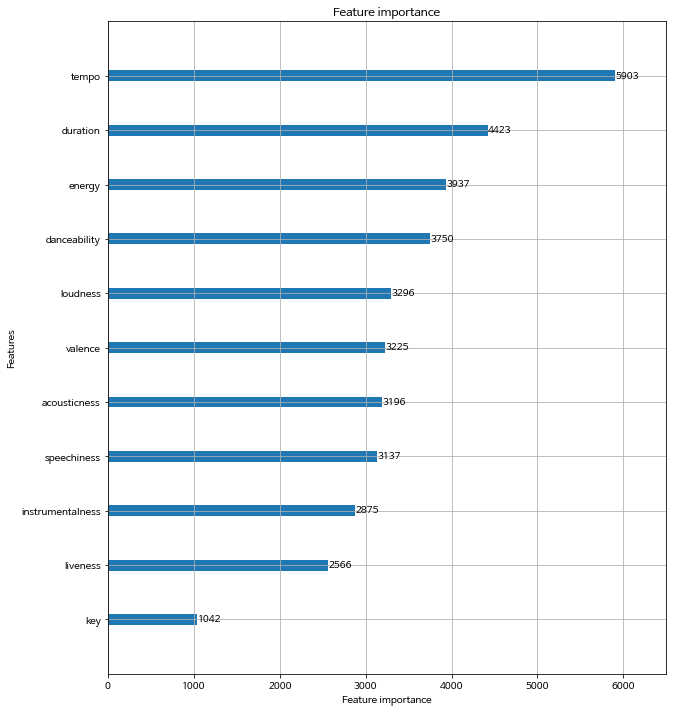

In [125]:
from lightgbm import plot_importance
fig, ax = plt.subplots(figsize = (10, 12))
plot_importance(model, ax=ax) #light gbm 모델에서 중요하게 여기는 요소를 확인했음. key보다는 tempo가 중요했음.

In [126]:
pred = model.predict(test) #test 데이터를 모델로 예측한 값을 pred 변수에 저장

In [51]:
submission = pd.read_csv("./sample_submission.csv") #sample 파일에 genre값에 모델로 test데이터를 예측한 값을 넣음
submission["genre"] = pred

In [52]:
submission #분류가 잘 되었는지 확인

,ID,genre
0,TEST_00000,Underground Rap
1,TEST_00001,Underground Rap
2,TEST_00002,hardstyle
3,TEST_00003,psytrance
4,TEST_00004,psytrance
5,TEST_00005,psytrance
6,TEST_00006,psytrance
7,TEST_00007,Underground Rap
8,TEST_00008,psytrance
9,TEST_00009,Underground Rap


In [38]:
submission.to_csv("./submit.csv", index = False) #제출용 파일 만듦

## 참고문헌
- https://www.kaggle.com/code/subinium/kakr-eda/notebook  
- https://rfriend.tistory.com/262
- https://blog.naver.com/aattspa/222936681800
- https://data-marketing-bk.tistory.com/28
- https://blog.naver.com/heetae185/222646465288
- https://blog.naver.com/dmz04/222755852813
- https://www.inflearn.com/questions/27184/eval-set%EA%B0%80-%EB%AD%90%ED%95%98%EB%8A%94%EA%B1%B4%EA%B0%80%EC%9A%94
- https://greatjoy.tistory.com/72
- https://www.inflearn.com/questions/208344/verbose-%EC%9D%98%EB%AF%B8
- https://github.com/Microsoft/LightGBM/issues/1483
- https://www.inflearn.com/questions/344831/lightgbm-eval-metric-%EC%A7%88%EB%AC%B8%EC%9E%85%EB%8B%88%EB%8B%A4
- https://blog.naver.com/bsh1004664/222684198433